# Examples of the ELO Python Client

## Connect to ELO

In [6]:
from decouple import AutoConfig
from eloservice.elo_service import EloService

config = AutoConfig(search_path='./') # load .env file from current directory with connection details
rest_baseurl = config("TEST_ELO_IX_URL")
rest_user = config("TEST_ELO_IX_USER")
rest_password = config("TEST_ELO_IX_PASSWORD")
elo_service = EloService(url=rest_baseurl, user=rest_user, password=rest_password)

### Load all sales

In [7]:
maskID = "33" #ID of our mask sales
results = elo_service.search(search_mask_id=maskID)

### Load all sales details

In [8]:
# checkout all results
checked_out = []
for result in results:
    sord = elo_service.checkout(result)
    checked_out.append(sord)
    print(sord.name)

Action definition
Firewall
Portait Lizenz - Spesenverwaltung
Portrait Lizenz - Inventory Management
sol.common_document.CreateCommunication
sol.common_document.PdfExport
sol.contact.as.actions.CreateContactReport
sol.contact.as.actions.CreateLabel
sol.contact.ix.actions.CreateCompany
sol.contact.ix.actions.CreateContact
sol.contact.ix.actions.CreateContactList
sol.contract.ContractConcluded
sol.contract.CreateCashFlowReport
sol.contract.CreateClause
sol.contract.CreateContract
sol.contract.CreateContractsReport
sol.contract.CreateCoverSheet
sol.contract.CreateDocument
sol.contract.CreateLabel
sol.contract.EditClauses
sol.contract.InitiateApproval
sol.contract.InitiateTermination
sol.contract.NegotiateContract
sol.contract.NegotiationCanceled
sol.contract.UpdateDocument
sol.dev.function.Deploy
sol.dev.function.Undeploy
sol.dev.ix.actions.CreatePackage
trskn.inventory.CreateAsset
Windows Server


We get a bunch of technical sords which we want to filter out.

In [9]:
import re
blacklist = ["Action definition", "sol.*", "trskn.inventory.*"]
cleaned = []
for result in checked_out:
    for black in blacklist:
        if re.match(black, result.name):
            break
    else:
        cleaned.append(result)
for result in cleaned:
    print(result.name)

Firewall
Portait Lizenz - Spesenverwaltung
Portrait Lizenz - Inventory Management
Windows Server


In [10]:
cleaned[0].obj_keys

[ObjKey(data=['Firewall'], display_data=<eloclient.types.Unset object at 0x0000021290465040>, id=0, name='SALE_NAME', obj_id=6250, additional_properties={}),
 ObjKey(data=['Infrastructure'], display_data=<eloclient.types.Unset object at 0x0000021290465040>, id=1, name='SALE_PRODUCT', obj_id=6250, additional_properties={}),
 ObjKey(data=['400.00'], display_data=<eloclient.types.Unset object at 0x0000021290465040>, id=2, name='SALE_AMOUNT', obj_id=6250, additional_properties={}),
 ObjKey(data=['20240310000000'], display_data=<eloclient.types.Unset object at 0x0000021290465040>, id=3, name='SALE_DATE', obj_id=6250, additional_properties={})]

In [11]:
## convert objkeys to a dict
def objkeys_to_dict(objkeys):
    return {objkey.name: objkey.data[0] for objkey in objkeys}

# for each cleaned sord, convert objkeys to a dict
data = [objkeys_to_dict(sord.obj_keys) for sord in cleaned]
data

[{'SALE_NAME': 'Firewall',
  'SALE_PRODUCT': 'Infrastructure',
  'SALE_AMOUNT': '400.00',
  'SALE_DATE': '20240310000000'},
 {'SALE_NAME': 'Portait Lizenz - Spesenverwaltung',
  'SALE_PRODUCT': 'Portrait License',
  'SALE_AMOUNT': '1000.00',
  'SALE_DATE': '20240315000000'},
 {'SALE_NAME': 'Portrait Lizenz',
  'SALE_PRODUCT': 'Portrait License',
  'SALE_AMOUNT': '800.00',
  'SALE_DATE': '20240318000000'},
 {'SALE_NAME': 'Windows Server',
  'SALE_PRODUCT': 'Infrastructure',
  'SALE_AMOUNT': '1500.00',
  'SALE_DATE': '20240310000000'}]

In [12]:
# Convert to pandas dataframe
import pandas as pd
df = pd.DataFrame(data)

In [13]:
df

,SALE_NAME,SALE_PRODUCT,SALE_AMOUNT,SALE_DATE
0,Firewall,Infrastructure,400.00,20240310000000
1,Portait Lizenz - Spesenverwaltung,Portrait License,1000.00,20240315000000
2,Portrait Lizenz,Portrait License,800.00,20240318000000
3,Windows Server,Infrastructure,1500.00,20240310000000


In [14]:
# convert SALE_AMOUNT to float
df["SALE_AMOUNT"] = df["SALE_AMOUNT"].astype(float)
# convert SALE_DATE to datetime
df["SALE_DATE"] = pd.to_datetime(df["SALE_DATE"])

df

,SALE_NAME,SALE_PRODUCT,SALE_AMOUNT,SALE_DATE
0,Firewall,Infrastructure,400.0,2024-03-10
1,Portait Lizenz - Spesenverwaltung,Portrait License,1000.0,2024-03-15
2,Portrait Lizenz,Portrait License,800.0,2024-03-18
3,Windows Server,Infrastructure,1500.0,2024-03-10


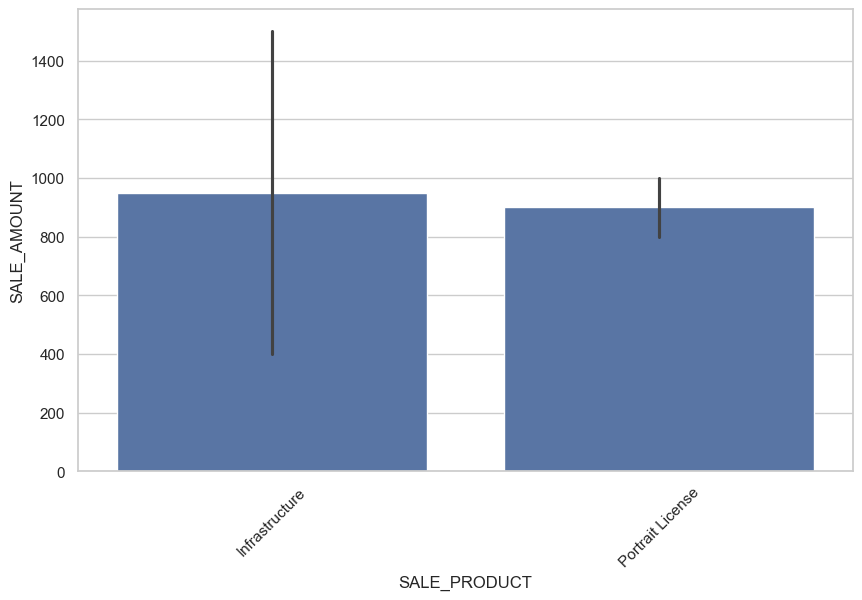

In [15]:
# generate a chart with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="SALE_PRODUCT", y="SALE_AMOUNT", data=df)
plt.xticks(rotation=45)
plt.savefig("sales.png", dpi=300, bbox_inches="tight")
plt.show()

## use reportlab to generate a PDF with the sale statistics chart and table

In [16]:
import io
import reportlab as rl
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle

# create a buffer
buffer = io.BytesIO()
# create a PDF
doc = SimpleDocTemplate(buffer, pagesize=letter)
# create a table
data = [df.columns[:,].tolist()] + df.values.tolist()
table = Table(data)
# add style
style = TableStyle([('BACKGROUND', (0, 0), (-1, 0), rl.lib.colors.grey),
                    ('TEXTCOLOR', (0, 0), (-1, 0), rl.lib.colors.whitesmoke),
                    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                    ('BACKGROUND', (0, 1), (-1, -1), rl.lib.colors.beige),
                    ('GRID', (0, 0), (-1, -1), 1, rl.lib.colors.black)])
table.setStyle(style)
# add table to the PDF
elements = [table, rl.platypus.Spacer(1, 12)]

# add some space

# add sales.png to the PDF
from reportlab.lib.pagesizes import letter
from reportlab.platypus import Image
img = Image("sales.png", 5*rl.lib.units.inch, 3*rl.lib.units.inch)
elements.append(img)

# add some space
elements.append(rl.platypus.Spacer(1, 12))

# add a barcode
from reportlab.graphics.barcode import code39
from reportlab.graphics.shapes import Drawing
d = Drawing(50, 10)
bc = code39.Extended39("1234567890", barWidth=0.5*rl.lib.units.mm, barHeight=15*rl.lib.units.mm)
elements.append(bc)

doc.build(elements)
# get the PDF as a byte string
pdf = buffer.getvalue()
buffer.close()

# save the PDF to a file
with open("sales.pdf", "wb") as f:
    f.write(pdf)
    

[sales.pdf](sales.pdf)